# Imports

I'm setting matplotlib to draw nice js widgets, and setting my system to look at the 'procgen-tools' lib that I'm editing, rather than the system version.

In [4]:
%matplotlib widget

In [5]:
# this allows editing of imported modules without restarting kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.insert(0,"/home/trist/progging/MIRL/procgen-tools")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from procgen_tools import maze

In [42]:
from procgen_tools import models

In [16]:
import torch as t

In [17]:
import numpy as np

In [227]:
import os

In [239]:
from pyndsp import to_ndsp_file

In [272]:
from scipy.cluster import hierarchy

# Select Maze

In [8]:
help(maze.create_venv)

Help on function create_venv in module procgen_tools.maze:

create_venv(num: int, start_level: int, num_levels: int, num_threads: int = 1)
    Create a wrapped venv. See https://github.com/openai/procgen#environment-options for params
    
    num=1 - The number of parallel environments to create in the vectorized env.
    
    num_levels=0 - The number of unique levels that can be generated. Set to 0 to use unlimited levels.
    
    start_level=0 - The lowest seed that will be used to generated levels. 'start_level' and 'num_levels' fully specify the set of possible levels.



In [9]:
venv = maze.create_venv(1, num_levels=1, start_level=100)

In [10]:
help(maze.venv_with_all_mouse_positions)

Help on function venv_with_all_mouse_positions in module procgen_tools.maze:

venv_with_all_mouse_positions(venv)
    From a venv with a single env, create a new venv with one env for each legal mouse position.
    
    Returns venv_all, (legal_mouse_positions, inner_grid_without_mouse)
    Typically you'd call this with `venv_all, _ = venv_with_all_mouse_positions(venv)`,
    The extra return values are useful for conciseness sometimes.



In [11]:
venv_all, (legal_mouse_positions, grid, ) = maze.venv_with_all_mouse_positions(venv)

In [32]:
all_mouse_pos = t.tensor(venv_all.reset(), dtype=t.float32)

In [40]:
# chosen because of the interesting position and shape of mouse
myMaze = all_mouse_pos[91].numpy().transpose((1,2,0))

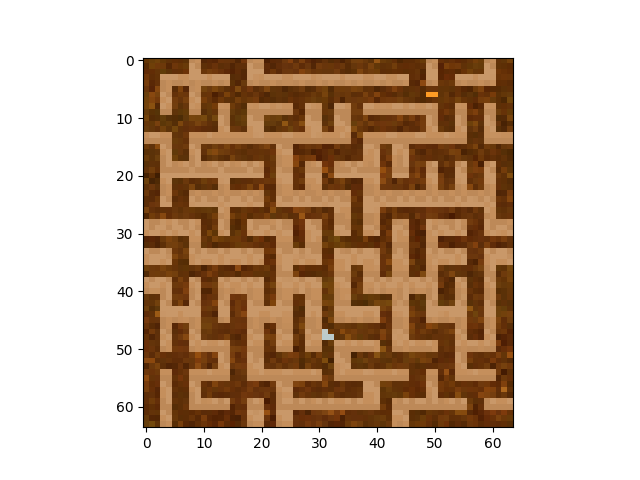

In [41]:
fig,ax = plt.subplots()
ax.imshow(myMaze)

# Get the Policy Model & Activations

## Load Model

In [44]:
myPolicy = models.load_policy('../trained_models/maze_I/model_rand_region_1.pth', 15, t.device('cpu'))

## Attach Hooks

In [167]:
activations = {}

In [142]:
def hook_fn(m, i, o):
    activations[m] = o 

In [216]:
def getHooked(mod):
    if len(mod._modules):
        submod = []
        for m in mod._modules:
            # apparently this can also be done with
            # mod.named_children()
            for k,v,h in getHooked(mod._modules[m]):
                if k:
                    submod+=((m+"."+k, v, h),)
                else:
                    submod+=((m, v, h),)
        return( submod )
    else:
        h = mod.register_forward_hook(hook_fn)
        return( (("",mod,h),) )

In [171]:
hookedList = getHooked(myPolicy.embedder)

In [184]:
len(hookedList)

40

## Run with Hooks

In [172]:
activations

{}

In [173]:
output = myPolicy(t.tensor(myMaze.transpose((2,0,1))).unsqueeze(0))

## Remove Hooks

In [ ]:
for name, layer, hook in hookedList:
    hook.remove()

## Print Info on Activation

In [189]:
#for name, layer, hook in hookedList:
#    print(name)
#    print("-----------")
#    print(layer)
#    print("-----------")
#    print(hook)
#    print("=========================================")

In [240]:
print("="*55+"\n"+"="*13+" "*5+"List of Activations"+" "*5+"="*13+"\n"+"="*55)
names_and_activations = []
for (k,v),(n,l,h) in zip(activations.items(),hookedList):
    print(f"{str(v.shape).rjust(30)} <-- {n}")
    names_and_activations += ((n,v),)

=============     List of Activations     =============
   torch.Size([1, 64, 64, 64]) <-- block1.conv
   torch.Size([1, 64, 32, 32]) <-- block1.maxpool
   torch.Size([1, 64, 32, 32]) <-- block1.res1.relu1
   torch.Size([1, 64, 32, 32]) <-- block1.res1.conv1
   torch.Size([1, 64, 32, 32]) <-- block1.res1.relu2
   torch.Size([1, 64, 32, 32]) <-- block1.res1.conv2
   torch.Size([1, 64, 32, 32]) <-- block1.res1.resadd
   torch.Size([1, 64, 32, 32]) <-- block1.res2.relu1
   torch.Size([1, 64, 32, 32]) <-- block1.res2.conv1
   torch.Size([1, 64, 32, 32]) <-- block1.res2.relu2
   torch.Size([1, 64, 32, 32]) <-- block1.res2.conv2
   torch.Size([1, 64, 32, 32]) <-- block1.res2.resadd
  torch.Size([1, 128, 32, 32]) <-- block2.conv
  torch.Size([1, 128, 16, 16]) <-- block2.maxpool
  torch.Size([1, 128, 16, 16]) <-- block2.res1.relu1
  torch.Size([1, 128, 16, 16]) <-- block2.res1.conv1
  torch.Size([1, 128, 16, 16]) <-- block2.res1.relu2
  torch.Size([1, 128, 16, 16]) <-- block2.res1.conv2
  torc

## Write Activations to Files

In [245]:
import datetime

In [252]:
now = datetime.datetime.now()

In [258]:
dirname = "activations_"+now.isoformat()

In [291]:
os.mkdir(dirname)

FileExistsError: [Errno 17] File exists: 'activations_2024-07-30T01:05:48.898678'

In [292]:
os.path.exists(dirname)

True

In [268]:
for name, activation in names_and_activations:
    to_ndsp_file( activation,
             labels = "zeros",
             title = dirname+"/"+name,
             dimAx = 1,
             afAx = None)

# Interpret Activations by Pixel "Color" Distribution

## Initial Classification by Clustering

### Reshape Activation to Pixels

In [282]:
layer_id = 0

In [283]:
print(names_and_activations[layer_id][0])

block1.conv


In [284]:
activation_img = names_and_activations[layer_id][1]

In [285]:
activation_img.shape

torch.Size([1, 64, 64, 64])

In [286]:
pixels = activation_img.reshape((64,-1))

### Build Hierarchy with scipy

In [360]:
pix_link = hierarchy.linkage(
    pixels.detach().numpy().transpose([1,0]),
    metric='euclidean',
    method='single',
    )

In [361]:
#link_tree = hierarchy.to_tree(pix_link)

### Dendrogram

/tmp/ipykernel_1661594/880322870.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


(-0.02, 0.6)

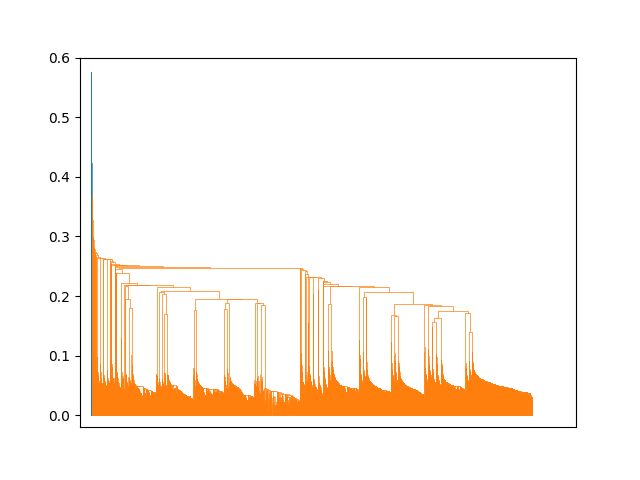

In [362]:
fig, ax = plt.subplots()
acf = ax.add_collection
# dendrogram doesn't have linewidth setting
# but it can be bodged on by hacking the axes
def linmodacf(colec):
    colec.set(linewidth=0.5,)
    acf(colec)
ax.add_collection = linmodacf

ddg=hierarchy.dendrogram(pix_link,
           count_sort='ascending',
           no_labels=True,
           ax=ax,
           )
ax.set_xlim([-1000,45000])
ax.set_ylim([-0.02,0.6])

### Classify by Hierarchy

In [367]:
classif = hierarchy.fcluster(
    pix_link,
    0.2,
    criterion='distance',
    depth=2,
    )

In [368]:
classif.min(), classif.max()

(1, 73)

## Interactive Pixel Cluster Labeling

In [307]:
classif.shape

(4096,)

Introducing "pixcluscol", an interactive coloring and labeling tool for interactively exploring the clusters (or otherwise obtained classifications) of the pixels in an image (especially useful when those pixels are 64 channel pixels).

In [404]:
from pixcluscol import InteractivePixCol

In [440]:
# Create a new Interactive Pixel Colorer giving it the pixel classes shaped back into an image (64x64 in this case)
pixCol = InteractivePixCol(  classif.reshape((64,64))  )

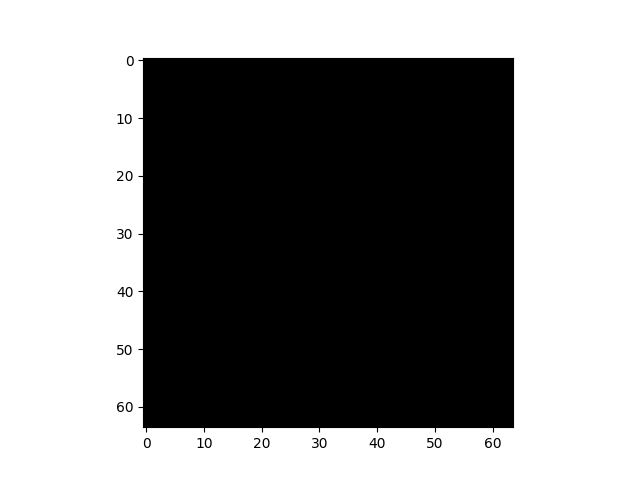

In [441]:
pixCol.drawPlot()

In [442]:
# Previous classifications can be printed out and loaded from text.
# This is somewhat strange, but allows for easily going back and forth
# between this tool and NDSP.

pixCol.loadClassif(

[[[186, 76, 254], [181, 76, 254], [186, 76, 254], [181, 76, 253], [167, 75, 251], [172, 75, 253], [176, 75, 251], [171, 75, 250], [183, 75, 250], [247, 82, 74], [238, 83, 71], [138, 71, 237], [241, 80, 72], [243, 81, 73], [176, 75, 253], [197, 75, 252], [185, 75, 253], [247, 74, 151], [186, 76, 254], [188, 75, 251], [255, 80, 76], [254, 76, 185], [208, 137, 62], [244, 85, 73], [253, 76, 175], [58, 180, 54], [64, 216, 148], [75, 119, 250], [67, 110, 224], [193, 75, 253], [254, 76, 139], [196, 75, 251], [181, 74, 248], [81, 44, 147], [254, 80, 76], [159, 73, 245], [250, 83, 75], [120, 47, 157], [175, 71, 239], [131, 56, 187], [156, 62, 208], [125, 42, 140], [182, 219, 65], [253, 84, 75], [110, 72, 33], [98, 253, 75], [172, 72, 241], [243, 236, 73], [251, 191, 75], [250, 202, 75], [251, 220, 75], [163, 68, 229], [73, 219, 244], [249, 76, 254], [75, 186, 252], [253, 237, 75], [72, 119, 242], [251, 203, 75], [66, 141, 221], [69, 99, 233], [253, 196, 75], [253, 205, 76], [244, 185, 73], [244, 193, 73], [251, 186, 75], [76, 149, 254], [69, 216, 231], [66, 181, 221], [66, 198, 220], [74, 137, 247], [73, 191, 244], [69, 145, 233], [69, 179, 233]], ["edge n wall ww", "edge w wall n", "edge n wall e", "edge n wall w", "edge w wall sss", "edge w wall ss", "edge n wall ee", "edge s wall w", "edge s wall ee", "oc nw", "ic se", "edge s wall e", "ic swe", "ic nwse", "edge w wall nn", "edge s wall ww", "edge e wall s", "oc swe", "edge w wall s", "edge e wall ?s", "oc se", "ic nese", "inner wall", "ic nw", "ic ne", "wall s", "wall e", "mouse nnww", "mouse ssww", "edge e wall n", "oc nes", "edge e wall ss", "edge s wall eee", "edge w", "ic nes", "edge e wall nn", "oc ne", "edge s", "edge sw", "edge n", "edge ne", "edge e", "wall w", "oc sw", "floor", "wall n", "edge se", "cheese ww", "cheese nee", "cheese see", "cheese ee", "edge nw", "mouse nee", "edge n wall ?", "mouse nne", "cheese nww", "mouse nww", "cheese e", "mouse ssw", "mouse sww", "cheese ne", "cheese nw", "cheese sw", "cheese w", "cheese se", "mouse nnw", "mouse see", "mouse sse", "mouse ssee", "mouse nw", "mouse ne", "mouse sw", "mouse se"], [51, 39, 39, 39, 39, 39, 39, 0, 3, 2, 6, 39, 39, 39, 39, 39, 39, 0, 3, 53, 2, 6, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 0, 3, 2, 6, 39, 39, 39, 39, 39, 39, 0, 3, 2, 6, 39, 40, 33, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 44, 45, 45, 45, 45, 10, 22, 26, 12, 45, 45, 45, 36, 44, 44, 42, 22, 22, 26, 12, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 36, 44, 44, 42, 22, 26, 44, 44, 44, 45, 45, 45, 45, 10, 22, 26, 44, 44, 41, 33, 44, 42, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 22, 26, 44, 44, 42, 9, 22, 22, 22, 22, 22, 26, 44, 44, 41, 33, 44, 42, 22, 23, 25, 25, 24, 22, 23, 25, 25, 25, 25, 20, 44, 44, 43, 17, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 44, 44, 43, 17, 20, 44, 44, 43, 17, 25, 25, 25, 25, 25, 20, 44, 44, 41, 33, 44, 42, 22, 26, 13, 44, 34, 21, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 55, 61, 60, 48, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 47, 63, 57, 50, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 44, 45, 36, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 36, 44, 44, 45, 45, 36, 44, 44, 45, 45, 36, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 62, 64, 49, 44, 44, 45, 36, 44, 44, 44, 45, 36, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 9, 30, 44, 44, 42, 9, 22, 22, 22, 22, 22, 22, 30, 44, 42, 9, 22, 30, 44, 42, 9, 22, 30, 44, 42, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 9, 30, 44, 44, 42, 9, 30, 44, 44, 41, 33, 44, 43, 17, 20, 44, 44, 43, 17, 20, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 23, 25, 25, 25, 25, 20, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 43, 17, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 26, 13, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 14, 45, 45, 45, 36, 44, 44, 44, 45, 45, 45, 45, 10, 22, 26, 12, 45, 10, 22, 22, 26, 12, 45, 45, 45, 45, 45, 10, 22, 22, 26, 12, 10, 22, 22, 26, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 10, 22, 26, 12, 45, 10, 22, 26, 44, 44, 42, 22, 26, 12, 45, 35, 1, 22, 22, 22, 30, 44, 44, 42, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 29, 5, 25, 24, 22, 26, 44, 44, 42, 22, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 22, 22, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 44, 42, 22, 22, 23, 25, 24, 22, 22, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 44, 44, 43, 17, 25, 25, 25, 16, 4, 44, 34, 21, 26, 44, 44, 42, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 13, 34, 21, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 31, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 41, 33, 44, 42, 22, 26, 12, 45, 10, 22, 26, 12, 45, 45, 45, 45, 45, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 44, 44, 45, 45, 36, 44, 44, 45, 45, 45, 45, 10, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 45, 36, 44, 44, 44, 45, 36, 44, 44, 44, 45, 36, 44, 44, 41, 33, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 26, 44, 42, 9, 22, 30, 44, 42, 9, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 9, 30, 44, 44, 42, 9, 30, 44, 44, 42, 9, 30, 44, 44, 41, 33, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 23, 25, 25, 25, 25, 25, 25, 25, 24, 22, 23, 25, 25, 25, 25, 25, 20, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 43, 17, 25, 25, 25, 24, 22, 22, 26, 44, 43, 17, 25, 20, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 13, 44, 44, 44, 44, 44, 44, 34, 21, 26, 13, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 44, 45, 45, 45, 45, 10, 22, 26, 12, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 12, 10, 22, 22, 26, 12, 45, 45, 45, 36, 44, 42, 22, 22, 26, 12, 45, 45, 45, 45, 45, 45, 10, 22, 26, 12, 45, 10, 22, 26, 12, 45, 10, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 44, 41, 33, 44, 43, 17, 20, 44, 44, 43, 17, 25, 25, 25, 24, 22, 23, 25, 25, 25, 25, 25, 20, 44, 43, 17, 25, 25, 25, 25, 25, 25, 25, 25, 24, 22, 22, 26, 44, 42, 22, 22, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 22, 26, 44, 44, 41, 33, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 44, 42, 22, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 26, 44, 44, 41, 14, 45, 45, 45, 45, 45, 45, 45, 45, 36, 44, 44, 42, 22, 26, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 36, 44, 44, 45, 45, 36, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 45, 45, 36, 44, 44, 44, 45, 45, 45, 45, 45, 45, 36, 44, 44, 42, 22, 26, 12, 45, 35, 1, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 22, 26, 44, 44, 42, 9, 22, 22, 22, 22, 22, 22, 30, 44, 42, 9, 22, 30, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 9, 22, 30, 44, 44, 42, 9, 22, 22, 22, 22, 22, 30, 44, 44, 42, 22, 22, 22, 22, 29, 18, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 19, 5, 25, 25, 25, 25, 25, 25, 24, 22, 26, 44, 44, 43, 17, 20, 44, 44, 43, 17, 25, 25, 25, 24, 22, 22, 26, 44, 42, 22, 22, 26, 44, 43, 17, 25, 20, 44, 43, 17, 25, 20, 44, 42, 22, 22, 26, 44, 44, 42, 22, 23, 25, 25, 25, 25, 20, 44, 44, 43, 17, 25, 25, 25, 16, 4, 44, 44, 44, 44, 44, 44, 34, 21, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 42, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 31, 14, 45, 45, 45, 36, 44, 44, 42, 22, 26, 12, 45, 45, 45, 45, 45, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 12, 10, 22, 22, 26, 44, 44, 45, 45, 45, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 44, 44, 42, 22, 26, 12, 45, 45, 45, 36, 44, 44, 44, 45, 45, 45, 45, 35, 1, 22, 22, 22, 30, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 9, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 9, 22, 22, 22, 29, 18, 22, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 19, 5, 25, 25, 25, 20, 44, 44, 43, 17, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 44, 42, 22, 22, 23, 25, 25, 25, 25, 20, 44, 42, 22, 22, 23, 25, 24, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 22, 23, 25, 25, 25, 25, 20, 44, 44, 42, 22, 23, 25, 25, 16, 4, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 13, 44, 44, 44, 44, 44, 42, 22, 22, 26, 13, 34, 21, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 22, 26, 13, 44, 44, 44, 44, 44, 44, 42, 22, 26, 13, 44, 31, 14, 45, 45, 45, 36, 44, 44, 44, 45, 36, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 12, 45, 45, 45, 36, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 12, 10, 22, 22, 26, 12, 45, 10, 22, 26, 44, 44, 44, 45, 36, 44, 44, 42, 22, 26, 44, 44, 41, 1, 22, 22, 22, 30, 44, 44, 42, 9, 30, 44, 44, 42, 9, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 9, 30, 44, 44, 42, 22, 26, 44, 44, 41, 18, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 5, 25, 24, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 23, 25, 25, 24, 22, 22, 26, 44, 42, 22, 22, 23, 25, 24, 22, 22, 26, 44, 42, 22, 22, 26, 44, 43, 17, 25, 25, 25, 24, 22, 22, 23, 25, 25, 24, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 4, 44, 34, 21, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 13, 44, 34, 21, 22, 26, 44, 42, 22, 22, 26, 13, 34, 21, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 13, 44, 34, 21, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 12, 45, 10, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 26, 12, 10, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 12, 45, 45, 45, 36, 44, 42, 22, 22, 26, 44, 44, 42, 22, 26, 12, 45, 10, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 23, 25, 25, 24, 22, 26, 44, 44, 43, 17, 20, 44, 44, 42, 22, 22, 23, 25, 24, 22, 22, 26, 44, 42, 22, 22, 26, 44, 43, 17, 25, 25, 25, 25, 25, 25, 20, 44, 42, 22, 22, 26, 44, 44, 43, 17, 25, 25, 25, 24, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 13, 44, 34, 21, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 13, 34, 21, 22, 26, 44, 42, 22, 22, 27, 65, 54, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 34, 21, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 56, 69, 70, 52, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 12, 45, 45, 45, 36, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 59, 71, 72, 66, 45, 45, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 12, 45, 45, 45, 36, 44, 44, 42, 22, 26, 12, 45, 10, 22, 26, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 42, 22, 22, 28, 58, 67, 68, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 22, 22, 22, 22, 22, 22, 26, 44, 44, 41, 33, 44, 43, 17, 20, 44, 44, 43, 17, 25, 25, 25, 24, 22, 26, 44, 44, 42, 22, 22, 26, 44, 43, 17, 25, 20, 44, 43, 17, 25, 20, 44, 42, 22, 22, 23, 25, 25, 25, 25, 20, 44, 43, 17, 25, 25, 25, 25, 25, 25, 20, 44, 44, 42, 22, 23, 25, 25, 25, 25, 20, 44, 44, 41, 33, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 26, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 13, 44, 44, 44, 44, 44, 44, 41, 33, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 41, 33, 44, 44, 45, 36, 44, 44, 44, 45, 45, 45, 45, 10, 22, 26, 44, 44, 42, 22, 22, 26, 12, 45, 45, 45, 45, 45, 45, 45, 45, 36, 44, 42, 22, 22, 26, 12, 45, 45, 45, 45, 45, 45, 45, 45, 36, 44, 44, 44, 45, 36, 44, 44, 42, 22, 26, 12, 45, 45, 45, 36, 44, 44, 41, 33, 44, 42, 9, 30, 44, 44, 42, 9, 22, 22, 22, 22, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 9, 30, 44, 44, 42, 22, 22, 22, 22, 22, 22, 30, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 23, 25, 25, 25, 25, 20, 44, 44, 43, 17, 25, 25, 25, 24, 22, 22, 23, 25, 25, 25, 25, 20, 44, 43, 17, 25, 25, 25, 24, 22, 22, 23, 25, 25, 25, 25, 20, 44, 44, 42, 22, 26, 44, 44, 43, 17, 25, 25, 25, 25, 25, 20, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 34, 21, 22, 26, 13, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 41, 33, 44, 42, 22, 26, 44, 44, 42, 22, 26, 12, 45, 45, 45, 36, 44, 44, 44, 45, 45, 36, 44, 42, 22, 22, 26, 12, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 10, 22, 22, 26, 44, 44, 45, 45, 45, 45, 45, 10, 22, 26, 12, 45, 45, 45, 36, 44, 44, 44, 45, 45, 45, 45, 35, 33, 44, 42, 22, 26, 44, 44, 42, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 9, 22, 30, 44, 42, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 44, 42, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 44, 44, 42, 9, 22, 22, 22, 29, 33, 44, 42, 22, 26, 44, 44, 43, 17, 25, 25, 25, 25, 25, 20, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 44, 42, 22, 22, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20, 44, 44, 43, 17, 25, 25, 25, 16, 33, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 13, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 31, 33, 44, 42, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 42, 22, 22, 26, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 41, 38, 37, 15, 7, 8, 32, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 15, 7, 11, 8, 32, 15, 7, 11, 8, 32, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 15, 7, 11, 8, 32, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 46]]

)

In [445]:
# This will print the above info unless you have made any changes.

# If you made changes and want to save them. Run this one first and save the output.
# Paste the output into the above call to loadClassif to restore it.
pixCol.printClassif()

[[[186, 76, 254], [181, 76, 254], [186, 76, 254], [181, 76, 253], [167, 75, 251], [172, 75, 253], [176, 75, 251], [171, 75, 250], [183, 75, 250], [247, 82, 74], [238, 83, 71], [138, 71, 237], [241, 80, 72], [243, 81, 73], [176, 75, 253], [197, 75, 252], [185, 75, 253], [247, 74, 151], [186, 76, 254], [188, 75, 251], [255, 80, 76], [254, 76, 185], [208, 137, 62], [244, 85, 73], [253, 76, 175], [58, 180, 54], [64, 216, 148], [75, 119, 250], [67, 110, 224], [193, 75, 253], [254, 76, 139], [196, 75, 251], [181, 74, 248], [81, 44, 147], [254, 80, 76], [159, 73, 245], [250, 83, 75], [120, 47, 157], [175, 71, 239], [131, 56, 187], [156, 62, 208], [125, 42, 140], [182, 219, 65], [253, 84, 75], [110, 72, 33], [98, 253, 75], [172, 72, 241], [243, 236, 73], [251, 191, 75], [250, 202, 75], [251, 220, 75], [163, 68, 229], [73, 219, 244], [249, 76, 254], [75, 186, 252], [253, 237, 75], [72, 119, 242], [251, 203, 75], [66, 141, 221], [69, 99, 233], [253, 196, 75], [253, 205, 76], [244, 185, 73], [244

## View Distribution in NDSP

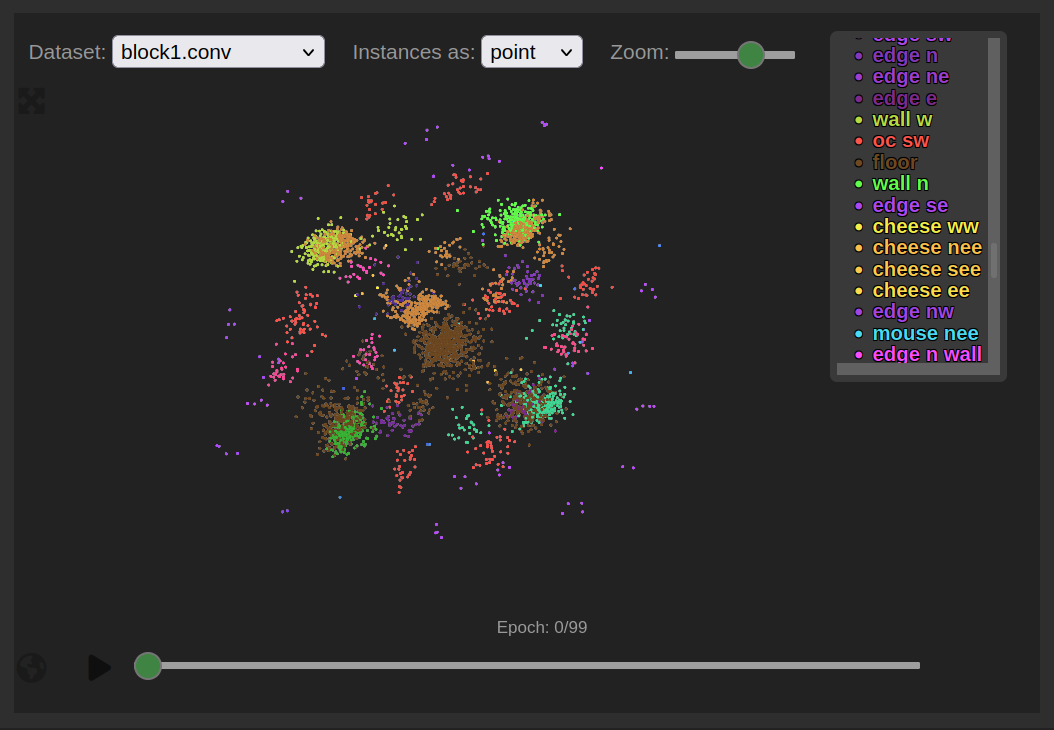